In [45]:
import numpy as np 
import cv2 as cv
import pandas as pd 
import random
# from pla import *
import os
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from IPython.display import display
import math

In [2]:
pd.read_csv('Final Data/Bicycle-8.csv')

,l ankle_knee,r ankle_knee,l knee_hip,r knee_hip,l wrist_elbow,r wrist_elbow,l elbow_shoulder,r elbow_shoulder,scale
0,0.000000,0.000000,0.000000,0.000000,222.308344,200.000000,217.082933,253.550784,6.291709
1,135.830777,0.000000,180.024998,236.315467,232.997854,153.117602,195.432853,253.639508,6.025147
2,92.227978,197.648678,235.416652,159.201131,103.247276,137.974635,94.403390,145.437272,3.319036
3,96.337947,162.000000,164.514437,209.086107,79.246451,67.911707,148.929514,117.686023,2.717199
4,228.569464,103.484298,259.724854,236.222353,108.461975,99.724621,124.277914,88.238314,3.529877
...,...,...,...,...,...,...,...,...,...
511,135.000000,146.812806,148.647233,148.922799,79.931220,0.000000,98.081599,97.493590,3.610704
512,129.495174,0.000000,115.312619,0.000000,104.292857,98.081599,92.347171,87.664132,3.120000
513,83.600239,71.063352,57.306195,57.140179,35.735137,50.566788,54.083269,48.846699,2.099143
514,134.014925,110.072703,82.024387,64.350602,61.032778,52.497619,39.051248,55.027266,2.424475


In [7]:
def min_max_norm(train_x, min_ = 0, max_ = 0):
    if type(min_) == int or type(max_) == int:
        min__ = np.min(train_x, axis = 0)
        max__ = np.max(train_x, axis = 0)
        data = (train_x-min__)/max__
        return data, min__, max__
    else: 
        data = (train_x-min_)/max_
        return data

In [103]:
def dataMaker(csv0, csv1):
    train_x0 = pd.read_csv(csv0).to_numpy()
    train_x1 = pd.read_csv(csv1).to_numpy()
    for i in range(len(train_x0)):
        train_x0[i][:-1] *= train_x0[i][-1]
    for i in range(len(train_x1)):
        train_x1[i][:-1] *= train_x1[i][-1]
    
    train_x0 = train_x0[:,:-1]
    train_x1 = train_x1[:,:-1]
    train_x = []
    train_y = [] 
    for i in train_x0:
        train_x.append(i)
        train_y.append(0)
    for i in train_x1:
        train_x.append(i)
        train_y.append(1)
    train_x =  np.asarray(train_x)
    train_y =  np.asarray(train_y)
    train_x, min_, max_ = min_max_norm(train_x)
    train_y[train_y==0] = -1
    #print(train_x.shape, train_y.shape)
    #np.save('E:\Manav Prabhakar\Courses\Department of Computer Science and Engineering\CSD 316 Introduction to Machine Learning\Project\train_min.npy', min_)
    #np.save('E:\Manav Prabhakar\Courses\Department of Computer Science and Engineering\CSD 316 Introduction to Machine Learning\Project\train_max.npy', max_)
    return train_x,train_y

train_x,train_y = dataMaker(r'Final Data\Bicycle-13.csv', r'Final Data\Walking-13.csv')

print(train_x.T.shape)
print(train_y.shape)


(8, 1093)
(1093,)


# Sklearn results to compare the metrics: 

In [9]:
log = LogisticRegression(random_state=0).fit(train_x, train_y)
print("Logistic Regression: ",log.score(train_x,train_y))

clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(train_x,train_y)
print("PLA: ",clf.score(train_x,train_y))

Logistic Regression:  0.565416285452882
PLA:  0.5452881976212259


# Utility function for Single Layer Perceptron

In [10]:
def sign(x):
    if x<0:
        return -1
    return 1


def hingLoss_point(point, true_class, w): # why hinge loss?: It is a convex function
    predicted =  predict(point, w)
    return max(0,1-true_class*predicted)

def hingeLoss_whole(data_x, data_y,w):
    s = 0 
    for i in range(len(data_x)): 
        s+= hingLoss_point(data_x[i], data_y[i], w)
    return s/len(data_x)

def correctPredict(point,true_class, w):
    predicted = predict(point, w)
    if true_class == 1 and sign(predicted) == 1:
        return True
    if true_class == -1 and sign(predicted) == -1: 
        return True
    return False

def accuracy(train_x, train_y, w):
    noSamples = len(train_y)
    acc = 0 
    for i in range(noSamples):
        if correctPredict(train_x[i], train_y[i], w) == True:
            acc+=1
    return acc/noSamples


def predict(point: list, w: list):
    ret = np.dot(w[:-1].T,point)+w[-1]
    return ret 
def predictClass(point, w):
    ret = predict(point, w)
    if sign(ret) == -1: 
        return 'Bicycling'
    return 'Walking'
def step(point, true_class, w, lr): # an implentation of Hinge loss, but with some heuristics
    predicted = predict(point, w)
    if predicted*true_class < 1:
        for i in range(len(w)):
            if i<len(w)-1:
                w[i]+= lr*(true_class)*point[i] 
            else: 
                w[i]+= lr*(true_class)
    else: 
        pass # is they are of same class then skip

# Training for a Single Layer Perceptron

In [11]:
stop_flag = 0
# domain = [np.min(train_x), np.max(train_x)] 
# w = np.random.random((train_x.shape[1]+1,1))
w = np.zeros((train_x.shape[1]+1,1))-1
highest_acc_weight = 0
highest_acc = 0
lowsest_loss_weight = 0
lowest_loss = 20
loss_matrix = [] # will contain loss after every epoch  
acc_matrix = []
for i in range(5):
    print("Iteration {}\t accuracy: {}".format(i, accuracy(train_x, train_y,w)))
    if stop_flag == 1:
        break
    t = time.time()
    for j in range(len(train_x)):
        step(train_x[j], train_y[j], w,0.01)
        
        acc = accuracy(train_x, train_y, w)
        acc_matrix.append(acc)
        if acc==1: # stopping criteria: when the accuracy of training set is 1
            print("\n\nIteration Stopped at: {}.{}\nAccuracy = {}\n".format(i,str(j/len(train_x))[2:],acc))
            stop_flag = 1
            break
        loss_matrix.append(hingeLoss_whole(train_x, train_y, w))
        if lowest_loss>hingeLoss_whole(train_x, train_y, w):
            lowest_loss = hingeLoss_whole(train_x, train_y, w)
            lowsest_loss_weight = w
        if highest_acc<acc:
            highest_acc = acc
            highest_acc_weight = w
    T = time.time()-t   
    
stop_flag = 0
print("Final Weights:",w)
print("Final Accuracy: {}".format(accuracy(train_x, train_y, w)))

Iteration 0	 accuracy: 0.47209515096065874
Iteration 1	 accuracy: 0.5388838060384263
Iteration 2	 accuracy: 0.5306495882891126
Iteration 3	 accuracy: 0.5288197621225984
Iteration 4	 accuracy: 0.5279048490393413
Final Weights: [[-0.48020465]
 [-0.46409719]
 [ 0.26592126]
 [-0.36837838]
 [-0.22253839]
 [-0.28595154]
 [ 0.18747168]
 [-0.18260055]
 [ 1.45      ]]
Final Accuracy: 0.5279048490393413


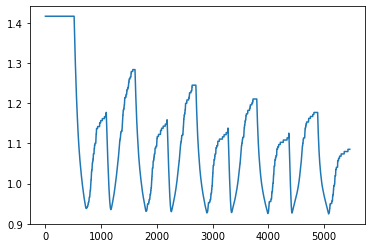

In [12]:
plt.plot(loss_matrix)

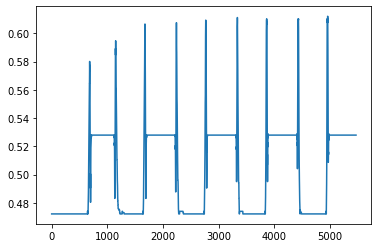

In [16]:
plt.plot(acc_matrix)

In [59]:
# -------------------------- Intentionally left blank --------------------------

# Importing the Test Data

In [26]:
testCSV = pd.read_csv('testData/test-8.csv')
display(testCSV)
test_x = testCSV.to_numpy()
min_ = np.load('Final Data/train_min.npy')
max_ = np.load('Final Data/train_max.npy')
test_x = min_max_norm(test_x, min_, max_)
print(test_x.shape)
imgNames = ['walking.jpeg', 'walking 1.jpeg', 'walking 2.jpeg', 'walking 4.jpeg', 'walking 3.jpeg', 'cycling.jpeg', 'cycling 2.jpeg', 'cycling 3.jpeg', 'cycling 4.jpeg', 'cycling 1.jpeg']
# imgNames = ['walking.jpeg', 'walking 1.jpeg', 'walking 2.jpeg', 'walking 4.jpeg', 'walking 3.jpeg', 'cycling.jpeg', 'cycling 2.jpeg', 'cycling 3.jpeg', 'cycling 4.jpeg', 'cycling 1.jpeg', 'imh.jpg']

,l ankle_knee,r ankle_knee,l knee_hip,r knee_hip,l wrist_elbow,r wrist_elbow,l elbow_shoulder,r elbow_shoulder
0,42.579338,37.121422,38.470768,34.014703,14.212670,0.000000,25.942244,0.000000
1,33.015148,36.055513,44.147480,43.185646,30.016662,27.073973,33.541020,35.440090
2,0.000000,0.000000,38.052595,40.199502,0.000000,0.000000,0.000000,0.000000
3,25.000000,24.020824,32.249031,31.256999,22.360680,23.409400,18.681542,18.681542
4,30.016662,44.384682,0.000000,45.099889,25.495098,26.248809,30.083218,30.265492
5,0.000000,0.000000,38.052595,42.011903,0.000000,27.073973,29.546573,25.709920
6,0.000000,0.000000,0.000000,55.226805,30.413813,28.635642,26.248809,28.071338
7,29.614186,16.000000,28.792360,25.317978,15.231546,14.317821,22.360680,22.203603
8,0.000000,0.000000,46.010868,46.486557,27.658633,0.000000,25.079872,0.000000
9,55.443665,58.051701,42.201896,38.078866,0.000000,40.718546,0.000000,34.014703


(10, 8)


# KNN - Basic and Modified/Weighted

In [21]:
def EuclideanDistance(Y, j, X, i):
    Distance = 0
    for k in range(len(Y)):
        Distance+=(Y[k][j]-X[k][i])**2
    return math.sqrt(Distance)

In [22]:
def WeightedSum(sortedArray,trainY,Distance,k):
    Weight = np.zeros(k)
    WeightedSum1 = 0
    WeightedSum2 = 0
    
    for j in range(k):
        if (Distance[sortedArray[k-1]]-Distance[sortedArray[0]])==0:
            Weight[j] = 0
        elif k>1:
            Weight[j] = (Distance[sortedArray[k-1]]-Distance[sortedArray[j]])/(Distance[sortedArray[k-1]]-Distance[sortedArray[0]]) 
        else:
            Weight[j] = 1
    
    for m in range(k):
        if trainY[sortedArray[m]]==1:
            WeightedSum1 += Weight[m]*Distance[sortedArray[m]]
        else:
            WeightedSum2 += Weight[m]*Distance[sortedArray[m]]
    return WeightedSum1,WeightedSum2

In [23]:
def classify(sortedArray,trainY,Distance,k,mode):
    if mode==0:
        C1,C2 = WeightedSum(sortedArray,trainY,Distance,k)    
    else:
        C1,C2 = normalKNN(sortedArray,trainY,Distance,k)
    if C1>C2:
        return -1,C1,C2   # For class 1
    else:
        return 1,C1,C2   # For class 2

In [38]:
def normalKNN(sortedArray,trainY,Distance,k):
    Weight = np.zeros(k)
    WeightedSum1 = 0
    WeightedSum2 = 0
    
    for j in range(k):
        Weight[j]=1
    
    for m in range(k):
        if trainY[sortedArray[m]]==1:
            WeightedSum1 += Weight[m]*Distance[sortedArray[m]]
        else:
            WeightedSum2 += Weight[m]*Distance[sortedArray[m]]
    return WeightedSum1,WeightedSum2

In [27]:
def predict(trainX,trainY,testSet,ExpectedY,k,mode):
    testSize = len(ExpectedY)
    trainSize = len(trainX[0])
    finalPred = np.zeros(testSize)
    C1 = np.zeros(testSize)
    C2 = np.zeros(testSize)
    sortedArray = np.zeros(trainSize)
    Distance = np.zeros((testSize,trainSize))
    for j in range(testSize):
        for i in range(trainSize):
            Distance[j][i] = EuclideanDistance(testSet,j,trainX,i)  
        sortedArray = np.argsort(Distance[j])
        finalPred[j],C1[j],C2[j] = classify(sortedArray,trainY,Distance[j],k,mode)
    
    return finalPred,C1,C2

In [28]:
def crossValidate(trainX,trainY,validX,validY,kRange,mode):
    validSize = len(validY)
    trainSize = len(trainX[0])
    Error = np.zeros((kRange,validSize))
    finalPred = np.zeros(validSize)
    avgError = np.zeros(kRange)
    for i in range(kRange):
        finalPred,C1,C2 = predict(trainX,trainY,validX,validY,i+1,mode)
        #Finding Error
        for j in range(len(C1)):
            Error[i][j] = 1-(np.sum(finalPred==validY))/(validSize)
            """
            if validY[j]==0:
                Error[i][j] = C1[j]/(C1[j]+C2[j])
            else:
                Error[i][j] = C2[j]/(C1[j]+C2[j])
            """

        avgError[i] = np.mean(Error[i])
    return avgError

In [29]:
#Splitting Data
def splitData(X,Y,fold,kRange,mode):
    train_X = np.zeros((8,900))
    train_Y = np.zeros(900)
    valid_X = np.zeros((8,100))
    valid_Y = np.zeros(100)
    Error = np.zeros((kRange,len(valid_Y)))
    finalError = np.zeros(kRange)
    avgError = np.zeros(kRange)
    i = 0
    j = 100
    
    groupSize = 100 #trainingSetSize/Number of folds(Here, 1000/10)
    trainSize = 1000 #trainingSet Size for cross-validation (Here, 1000 - 100)
    for m in range(fold):
        for q in range(8):
            train_X[q][0:i] = X[q][0:i] 
        
        p = (int)(trainSize-groupSize)
        
        for q in range(8):
            train_X[q][i:p] = X[q][j:1000]
        
        for q in range(8):
            train_X[q][i:p] = X[q][j:1000]
        
        
        train_Y[0:i] = Y[0][0:i]
        train_Y[i:p] = Y[0][j:1000]
    
        for q in range(8):
            valid_X[q] = X[q][i:j]
        
        
        valid_Y = Y[0][i:j]
        
        Error = crossValidate(train_X,train_Y,valid_X,valid_Y,kRange,mode)
        finalError += Error 
        i+=100
        j+=100
        

    avgError = finalError/fold

    reqK = np.argmin(avgError)  
    return reqK+1,avgError

In [34]:
def testTrain(X,Y,testX,testY,k,test_size,mode):
    y_hat = np.zeros(test_size)
    C1 = np.zeros(test_size)
    C2 = np.zeros(test_size) 
    y_hat,c1,c2 = predict(X,Y,testX,testY,k,mode)
    #print("Predicted Y: ",y_hat)
    #print("Expected Y: ",testY)
    Accuracy = (np.sum(y_hat==testY)/test_size)
    #print("TestY: ",testY)
    #print("Y_hat",y_hat)
    #print("Train Accuracy for k = " + (str)(k) + ": " + (str)(Accuracy*100) + "%")
    return Accuracy,y_hat

In [31]:
X = np.zeros((8,1000))
for q in range(8):
    X[q][:1000] = train_x.T[q][:1000]
#X = train_x.T
fold = 10
kRange = 30
Y = np.zeros((1,1000))
for q in range(1000):
    Y[0][q] = train_y[q]
#Finding optimal K value using 2-fold cross validation


The 3 subsequent cells will take a long time to compute. The results for these code snippets can be found in the report under the title "Training Error for NN Algorithms"

In [120]:
mode = 0
fold = 10
kRange = 30
k_optimal,Error = (splitData(X,Y,fold,kRange,mode))
print("Optimal value for k : ",k_optimal)
print("Error = ",Error)

In [ ]:
fold = 10
kRange = 30
mode = 1
k_optimal,Error1 = (splitData(X,Y,fold,kRange,mode))
print("Optimal value for k : ",k_optimal)
print("Error = ",Error1)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(Error,label="Weighted KNN")
plt.plot(Error1,label="Basic KNN")
plt.legend()
plt.title("Error rate vs K-value")
plt.xlabel("K-value")
#plt.axis('equal')
#plt.xscale('log')
plt.yscale('log')
plt.ylabel("Error Rate")
#plt.plot(Accuracy)
plt.show()

In [102]:
train_size = 1000
test_size = 10
k = 20
mode = 0
testY = np.zeros((1,10))
for z in range(5):
    testY[0][z] = 1
for z in range(5):
    testY[0][z+5] = -1
Y_hat = np.zeros(10)
Accuracy = np.zeros(30) 
for t in range(30):
    Accuracy[t],Y_hat=testTrain(X,Y[0],test_x.T,testY[0],t+1,test_size,mode)
print("Maximum Test Accuracy: " + (str)(np.max(Accuracy)*100) + "%")

Maximum Test Accuracy: 70.0%


In [119]:
train_size = 1000
test_size = 10
k = 20
mode = 1
testY = np.zeros((1,10))
for z in range(5):
    testY[0][z] = 1
for z in range(5):
    testY[0][z+5] = -1
Y_hat1 = np.zeros(10)
Accuracy1 = np.zeros(30)  
for t in range(30):
    Accuracy1[t],Y_hat1=testTrain(X,Y[0],test_x.T,testY[0],t+1,test_size,mode)
print("Maximum Test Accuracy: " + (str)(np.max(Accuracy1)*100) + "%")
print(Y_hat1)

Maximum Test Accuracy: 80.0%
[ 1.  1. -1.  1.  1. -1. -1. -1. -1.  1.]


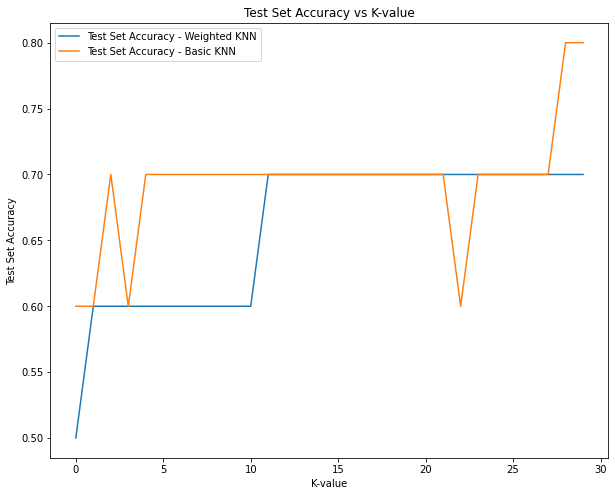

In [41]:
plt.figure(figsize=(10,8))
plt.plot(Accuracy,label="Test Set Accuracy - Weighted KNN")
plt.plot(Accuracy1,label="Test Set Accuracy - Basic KNN")
plt.legend()
plt.title("Test Set Accuracy vs K-value")
plt.xlabel("K-value")
#plt.axis('equal')
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel("Test Set Accuracy")
#plt.plot(Accuracy)
plt.show()

In [109]:
def finalPredict(imageName,Y_hat):
    fig = plt.figure(figsize=(30,15))
    plt.title("Inference - KNN", fontsize = "35")
    #fig.sharey()
    cols = 5
    rows = 2
    for i in range(len(Y_hat)):
        img = cv.imread('testData/'+imageName[i])
        if Y_hat[i]<0: 
            flag = "Bicycling"
            
        else: 
            flag = "Walking"
        
        fig.add_subplot(rows, cols, i+1).sharey
        #ax[i].sharey
        plt.title(flag,fontsize = '25')
        plt.imshow(img)
        
    #plt.show()

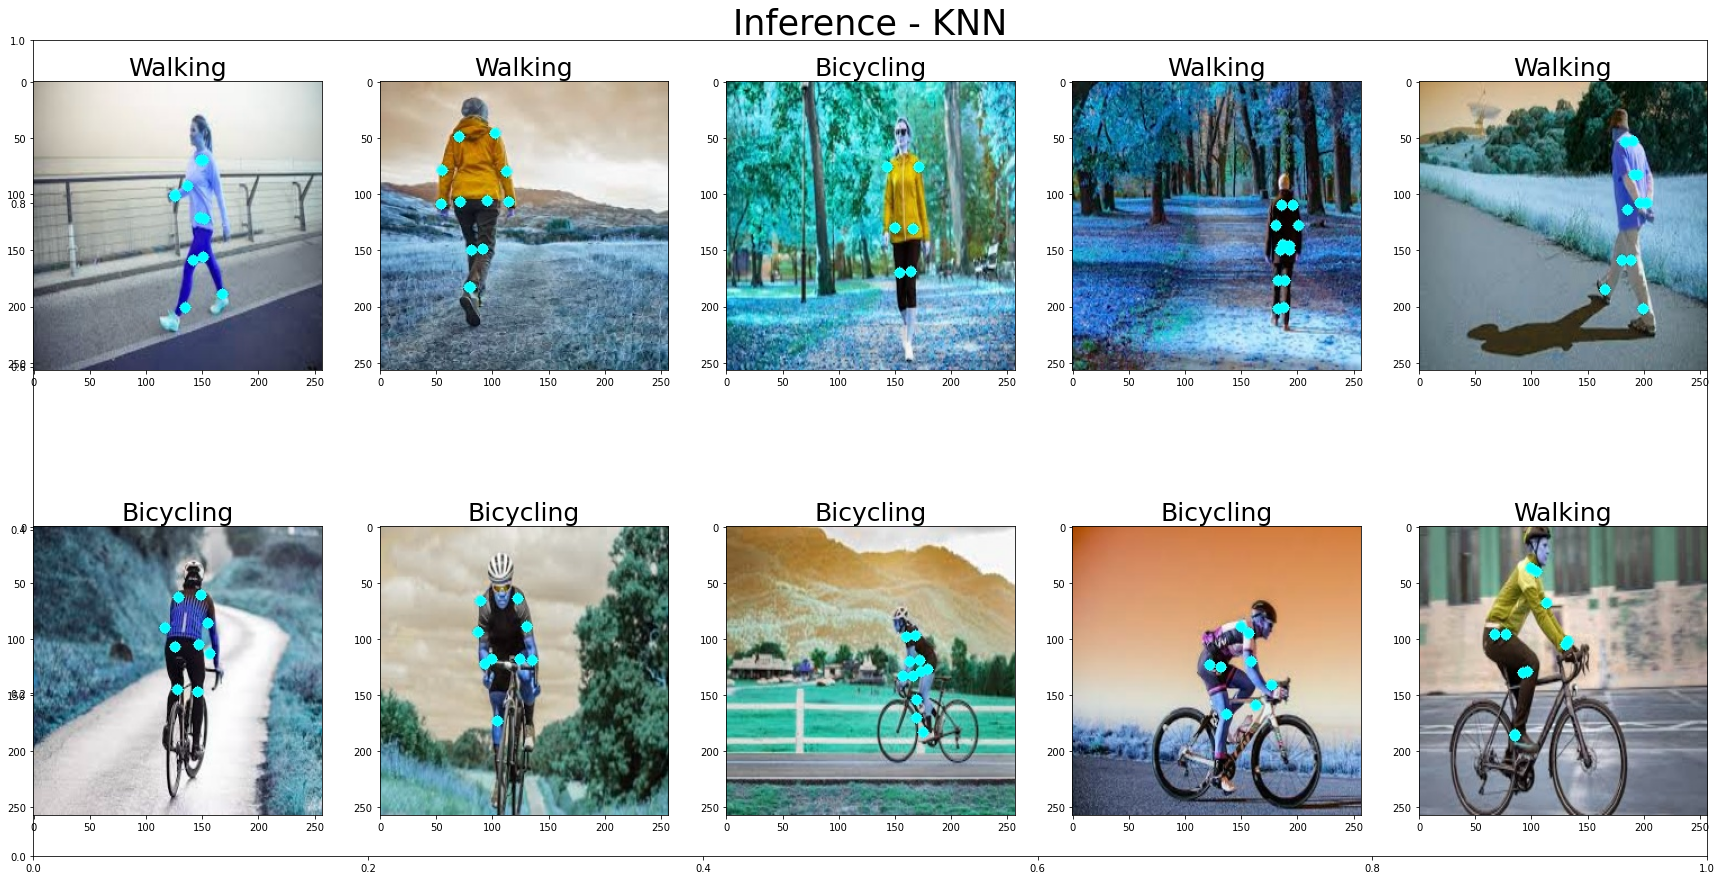

In [117]:
finalPredict(imgNames,Y_hat1)

# Logistic Regression

In [87]:
train_size = 500
m = train_size
X = np.zeros((8,2*m))
Y = np.zeros((1,2*m))

for q in range(8):
    X[q][:1000] = train_x.T[q][:1000]

Y = np.zeros((1,1000))
for q in range(1000):
    if train_y[q]==-1:
        Y[0][q] = 0
    else:
        Y[0][q] = train_y[q]

In [88]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [89]:
def Activation(G,Y_hat,m):
  for i in range ((int)(2*m)):
    temp = G[0][i]
    if sigmoid(temp) >= 0.5 :
      Y_hat[0][i] = 1
    else:
      Y_hat[0][i] = 0
  return Y_hat

In [90]:
def trainLR(X,Y,m):
    dz = np.zeros((1,2*m))
    alpha = 0.005
    Y_hat = np.zeros((1,2*m))
    G = np.zeros((1,2*m))
    Weight = np.zeros((1,8)) 
    bias = np.zeros((1,2*m)) 

    iterations = 5000
    trainAccuracy = np.zeros((int)(iterations/500))
    i=0
    biasChange = np.zeros((int)(iterations))
    for t in range(iterations):   
        G = np.dot(Weight,X) + bias
        Y_hat = Activation(G,Y_hat,m)
        dz = Y_hat-Y
        dw = (np.dot(dz,X.T))/(2*m)
        db = (1/(2*m))*np.sum(dz)
        Weight = Weight - alpha*dw
        bias = bias - alpha*db   
        biasChange[t] = bias[0][1]
        if t % 500 == 0:
          #print("Accuracy: ",(np.sum(Y_hat==Y)/(2*m)))
          trainAccuracy[i] = 1-((np.sum(Y_hat==Y)/(2*m)))
          i+=1
          if (np.sum(Y_hat==Y)/(2*m))==1:
              print("Maximum training accuracy attained!")
              break

    G = np.dot(Weight,X) + bias
    return Weight,bias,trainAccuracy,biasChange

In [93]:
iterations = 5000
Weight = np.zeros((1,8)) 
bias = np.zeros((1,2*m)) 
biasChange = np.zeros((int)(iterations))
train_size = 500
trainAccuracy = np.zeros((int)(iterations/500))
Weight,bias,trainAccuracy,biasChange = trainLR(X,Y,train_size)
#print(Weight)
#print(bias)

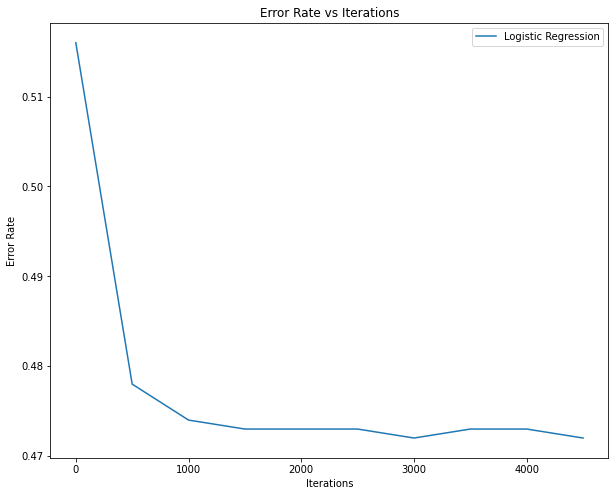

In [94]:
IterationIndex = [0,500,1000,1500,2000,2500,3000,3500,4000,4500]
plt.figure(figsize=(10,8))
plt.plot(IterationIndex,trainAccuracy,label="Logistic Regression")
plt.legend()
plt.title("Error Rate vs Iterations")
plt.xlabel("Iterations")
#plt.axis('equal')
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel("Error Rate")
#plt.plot(Accuracy)
plt.show()
#plt.plot(IterationIndex)

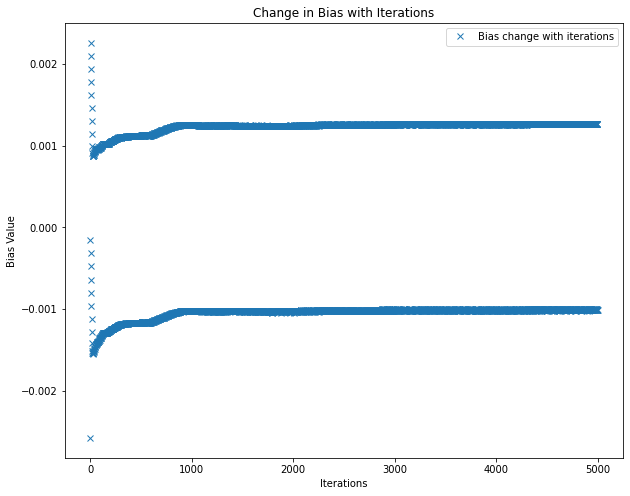

In [95]:
plt.figure(figsize=(10,8))
#plt.hist(biasChange, bins = 10)
plt.plot(biasChange,'x',label="Bias change with iterations")
plt.legend()
plt.title("Change in Bias with Iterations")
plt.xlabel("Iterations")
plt.ylabel("Bias Value")
plt.show()

In [98]:
test_size = 10
testY = np.zeros((1,10))
for z in range(5):
    testY[0][z] = 1
for z in range(5):
    testY[0][z+5] = 0
    
test_Y_hat = np.zeros((1,test_size))
testBias = np.zeros((1,test_size))
testBias[0][:test_size] = bias[0][0:test_size]

G = np.dot(Weight,test_x.T) + testBias
test_Y_hat = Activation(G,test_Y_hat,test_size/2)
testAccuracy = (np.sum(test_Y_hat==testY[0])/test_size)
print("Test Accuracy: " + (str)(testAccuracy*100) + "%")

Test Accuracy: 50.0%
